In [ ]:
from connection import * 
import numpy as np
from sqlalchemy import create_engine 
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif


np.random.seed(42)

warnings.filterwarnings('ignore')

DB_HOST = DB_HOST
DB_NAME = DB_NAME
DB_USER = DB_USER       
DB_PASS = DB_PASS       
DB_PORT = DB_PORT              

engine = create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

def get_boolean_columns(engine, schema, table_name):
    """Get the right schema and table name for the boolean columns."""
    query = f"""
            SELECT column_name
            FROM information_schema.columns
            WHERE table_schema = '{schema}' AND table_name = '{table_name}' AND data_type = 'boolean';
            """
    result = pd.read_sql(query, engine)
    return result['column_name'].tolist()

clinical = pd.read_sql('SELECT * FROM project.clinical', engine)
pain = pd.read_sql('SELECT * FROM project.pain', engine)
patient = pd.read_sql('SELECT * FROM project.patient', engine)
psychological = pd.read_sql('SELECT * FROM project.psychological', engine)
radvice = pd.read_sql('SELECT * FROM project.radvice', engine)
work = pd.read_sql('SELECT * FROM project.work', engine)

In [ ]:
def convert_bool_to_int(table, engine, table_name):   
    """Get Boolean columns from PostgreSQL and convert them to int64 to overcome with NANs""" 
    bool_cols = get_boolean_columns(engine, 'project', table_name)
    for col in bool_cols:
        table[col] = table[col].astype('Int64')
    return table

clinical = convert_bool_to_int(clinical, engine, 'clinical')
pain = convert_bool_to_int(pain, engine, 'pain')
patient = convert_bool_to_int(patient, engine, 'patient')
psychological = convert_bool_to_int(psychological, engine, 'psychological')
radvice = convert_bool_to_int(radvice, engine, 'radvice')
work = convert_bool_to_int(work, engine, 'work')
#patient.serious_disease.value_counts(dropna=False)

In [49]:
# Join all the tables
df_merged = radvice.merge(patient, left_on='patient_id', right_on='patient_id', how='left')
df_merged = df_merged.merge(clinical, left_on='patient_id', right_on='patient_id', how='left')
df_merged = df_merged.merge(psychological, left_on='patient_id', right_on='patient_id', how='left')
df_merged = df_merged.merge(pain, left_on='patient_id', right_on='patient_id', how='left')
df_merged = df_merged.merge(work, left_on='patient_id', right_on='patient_id', how='left')
df_merged = df_merged.drop(columns=['patient_id','treatment_description'])
print("Check final size of df: ", len(df_merged))

df = df_merged.copy()

# continous
continous_columns =  [
    'decreased_mobility',
    'weightloss_per_year',
    'extremely_nervous',
    'irrational_thoughts_risk_lasting',
    'coping_strategy',
    'kinesiophobia_physical_exercise',
    'kinesiophobia_pain_stop',
    'nocturnal_pain',
    'continuous_pain',
    'duration_of_pain',
    'neck_pain_intensity',
    'low_back_pain_intensity',
    'arm_left_pain_intensity',
    'arm_right_pain_intensity',
    'leg_left_pain_intensity',
    'leg_right_pain_intensity'
]
df[continous_columns] = df[continous_columns].astype(float)

cat_cols = [col for col in df.columns if str(df[col].dtype).lower().startswith('int')]
print("Categorical features (Int64):", cat_cols)

Check final size of df:  1527
Categorical features (Int64): ['treatment', 'family_history', 'serious_disease', 'fever', 'uses_analgesics', 'uses_corticosteroids', 'neurogenic_signals', 'loss_muscle_strength', 'failure_symptoms', 'depression', 'stress', 'sick_leave', 'earlier_hospitalization', 'paidwork']


In [ ]:
# Convert age to numerical
df['age'] = df['age'].map({
    '0-19': 10, '20-29': 25, '30-39': 35, '40-49': 45,
    '50-59': 55, '60-69': 65, '70-79': 75, '>=80': 85
}).astype(float)

# Separate features (X) and target (y).
X, y = df.drop(columns=['treatment']), df['treatment']
column_names = X.columns
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
#print("Missing before:", np.isnan(X).sum())

# Custom transformer for feature engineering.
class CustomFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Convert array back to DataFrame so we can manipulate columns by name
        df = pd.DataFrame(X, columns=self.column_names)
        
        # Arm, leg, neck
        df['arm_pain'] = ((df['arm_left_pain_intensity'] > 0) | (df['arm_right_pain_intensity'] > 0)).astype('Int64')
        df['leg_pain'] = ((df['leg_left_pain_intensity'] > 0) | (df['leg_right_pain_intensity'] > 0)).astype('Int64')
        df['neck_pain'] = (df['neck_pain_intensity'] > 0).astype('Int64')

        # Kinesiophobia
        df['kinesiophobia'] = df[['kinesiophobia_pain_stop','kinesiophobia_physical_exercise']].mean(axis=1)

        df = df.drop(columns=['kinesiophobia_pain_stop','kinesiophobia_physical_exercise',
                              'arm_left_pain_intensity','arm_right_pain_intensity',
                                'leg_left_pain_intensity','leg_right_pain_intensity',
                                'neck_pain_intensity',
                                ])
        
        return df
    
fe = CustomFeatureEngineer(column_names=column_names)
X_fe = fe.fit_transform(X)
X_fe_df = pd.DataFrame(X_fe, columns=fe.transform(pd.DataFrame(X, columns=column_names)).columns)
print("Shape of X:", X_fe_df.shape)


Shape of X: (1527, 30)
Shape of y: (1527,)
Shape of X: (1527, 27)


# Modeling: considering all treatment types

In [25]:
#X_fe = pipeline.named_steps['feature_engineering'].transform(X_train)
#cat_cols = [i for i, dt in enumerate(X_fe.dtypes) if dt.name == 'Int64']
print("Categorical feature indices for SMOTENC:", cat_cols)
cat_cols_idx =[1, 2, 3, 4, 5, 6, 9, 10, 11, 13, 20, 21, 22, 23, 24, 25]

X_train, X_test, y_train, y_test = train_test_split(
    X_fe_df, y, test_size=0.2, stratify=y, random_state=42
)

Categorical feature indices for SMOTENC: ['treatment', 'family_history', 'serious_disease', 'fever', 'uses_analgesics', 'uses_corticosteroids', 'neurogenic_signals', 'loss_muscle_strength', 'failure_symptoms', 'depression', 'stress', 'sick_leave', 'earlier_hospitalization', 'paidwork']


## Random Forest

In [ ]:
over = SMOTE(sampling_strategy='not majority', random_state=42)
over2 = SMOTENC(categorical_features=cat_cols_idx, sampling_strategy='all', random_state=42)
under = RandomUnderSampler(sampling_strategy='not minority', random_state=42)

pipeline = ImbPipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50, skip_complete=True)),
    #('smote', over),  # activate for oversampling
    #('undersample', under),   # activate for undersampling
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced',n_estimators = 1000, random_state = 42))
])

pipeline.fit(X_train, y_train)
score = pipeline.score(X_test, y_test)
print(f"Test score: {score:.4f}")
from sklearn.metrics import classification_report

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred,))


# STRATIFIED cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv)
print(f"Mean CV accuracy:: {scores.mean():.4f}")

Test score: 0.5229
              precision    recall  f1-score   support

           1       0.54      0.63      0.58       131
           2       0.00      0.00      0.00        32
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         3
           5       0.51      0.61      0.55       128

    accuracy                           0.52       306
   macro avg       0.21      0.25      0.23       306
weighted avg       0.44      0.52      0.48       306



## Random forest with PCA

### PC: 10

In [ ]:
pipeline = ImbPipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50)),
    ##('smote', over),  # activate for oversampling
    ##('undersample', under),   # activate for undersampling
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('classifier', RandomForestClassifier(class_weight='balanced',n_estimators=1000,random_state=42))
])

pipeline.fit(X_train, y_train)

test_score = pipeline.score(X_test, y_test)
print(f"Random Forest on PCA features - Test score: {test_score:.4f}")

y_pred = pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Random Forest on PCA features - Test score: 0.3954
Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.47      0.47       131
           2       0.22      0.28      0.25        32
           3       0.15      0.17      0.16        12
           4       0.10      0.33      0.15         3
           5       0.43      0.37      0.40       128

    accuracy                           0.40       306
   macro avg       0.27      0.32      0.29       306
weighted avg       0.41      0.40      0.40       306



### PC=4

In [ ]:
# Create pipeline up to PCA
pipeline_pca = ImbPipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50)),
    #('smote', over),  # activate for oversampling
    #('undersample', under),   # activate for undersampling
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=4))
])

X_train_pca = pipeline_pca.fit_transform(X_train, y_train)
X_test_pca = pipeline_pca.transform(X_test)

clf_pca = RandomForestClassifier(class_weight='balanced', n_estimators=1000, random_state=42)
clf_pca.fit(X_train_pca, y_train)
test_score = clf_pca.score(X_test_pca, y_test)
print(f"Random Forest on PCA features - Test score: {test_score:.4f}")

Random Forest on PCA features - Test score: 0.4641


## Feature Selection with Univariate Statistical Tests

Test score with SelectKBest: 0.4084967320261438
Mean CV score with SelectKBest: 0.40277081324333014
Selected features: ['age', 'family_history', 'fever', 'uses_corticosteroids', 'stress', 'coping_strategy', 'continuous_pain', 'paidwork', 'leg_pain', 'neck_pain']


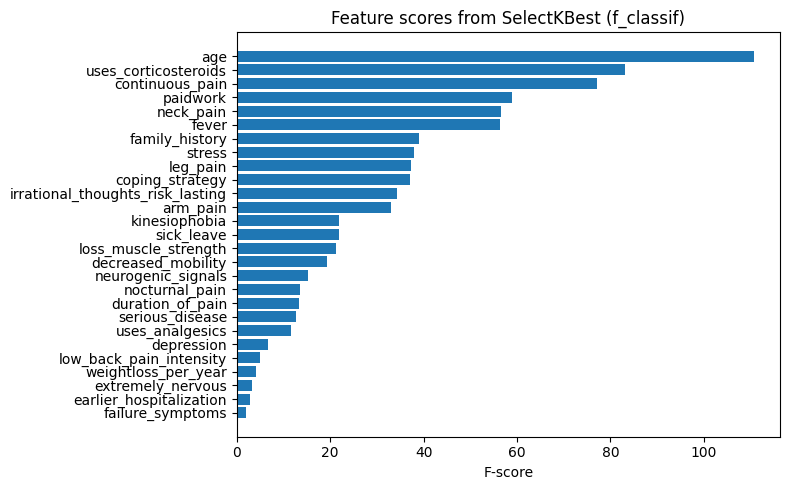

In [ ]:
#Feature Selection with Univariate Statistical Tests
from sklearn.feature_selection import SelectKBest, f_classif

pipeline_kbest = ImbPipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50, skip_complete=True)),
    ('smote', over),  # activate for oversampling
    ('undersample', under),   # activate for undersampling
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k=10)),  # <-- Select top 10 features
    ('classifier', RandomForestClassifier(class_weight='balanced',n_estimators=1000,random_state=42))
])
pipeline_kbest.fit(X_train, y_train)
score_kbest = pipeline_kbest.score(X_test, y_test)
print("Test score with SelectKBest:", score_kbest)

cv_scores_kbest = cross_val_score(pipeline_kbest, X, y, cv=5)
print("Mean CV score with SelectKBest:", cv_scores_kbest.mean())
selector = pipeline_kbest.named_steps['select']
selected_mask = selector.get_support()


## get feature names
final_names = X_fe_df.columns
selected_feature_names_ust = np.array(final_names)[selected_mask]
print("Selected features:", selected_feature_names_ust.tolist())

scores = selector.scores_

# Sort features and scores by score descending
sorted_indices = np.argsort(scores)[::-1]
sorted_names = np.array(final_names)[sorted_indices]
sorted_scores = scores[sorted_indices]

plt.figure(figsize=(8, 5))
plt.barh(sorted_names, sorted_scores)
plt.xlabel("F-score")
plt.title("Feature scores from SelectKBest (f_classif)")
plt.gca().invert_yaxis()  # Highest score on top
plt.tight_layout()
plt.show()


In [19]:
### re-run the pipeline with selected features

selected_feature_names = np.array(final_names)[selector.get_support()]
selector = pipeline_kbest.named_steps['select']
mask = selector.get_support()
selected_feature_names = np.array(final_names)[mask]
X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]
pipeline_rf_selected = ImbPipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50, skip_complete=True)),
    ('smote', over),  # optionally add oversampling
    ('undersample', under),  # optionally add undersampling
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        n_estimators=500,
        random_state=42
    ))
])

pipeline_rf_selected.fit(X_train_selected, y_train)
score = pipeline_rf_selected.score(X_test_selected, y_test)
print("Test score (RF with selected features):", score)


Test score (RF with selected features): 0.42483660130718953


In [36]:
### gridsearchiamoooooooooo
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the pipeline without a fixed n_components for PCA
pipeline = ImbPipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50)),
    ('scaler', StandardScaler()),
    ('pca', PCA()),  # n_components to be tuned via grid search
    ('classifier', RandomForestClassifier(class_weight='balanced', n_estimators=1000, random_state=42))
])

# Define the parameter grid for PCA components
param_grid = {
    'pca__n_components': [5, 10, 15, 20]  # adjust based on your dataset's dimensionality
}

# Set up GridSearchCV to tune n_components with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Evaluate on test set
test_score = grid_search.score(X_test, y_test)
print(f"Random Forest on PCA features - Test score: {test_score:.4f}")

y_pred = grid_search.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Best parameters: {'pca__n_components': 15}
Best cross-validation score: 0.4717
Random Forest on PCA features - Test score: 0.4673
Classification Report:
              precision    recall  f1-score   support

           1       0.48      0.60      0.53       131
           2       0.50      0.03      0.06        32
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         3
           5       0.45      0.50      0.47       128

    accuracy                           0.47       306
   macro avg       0.29      0.23      0.21       306
weighted avg       0.45      0.47      0.43       306



<hr>

# Modeling with only treatment 1 and 5,  (no treatment vs treament) --> convert to binary variable

In [56]:
df_only1_5 = df.loc[df['treatment'].isin([1,5])]
print("N of observations with only 1 and 5:", len(df_only1_5))

# Separate features (X) and target (y).
X, y = df_only1_5.drop(columns=['treatment']), df_only1_5['treatment']
y = y.replace({1: 0, 5: 1})
print(y.value_counts())

column_names = X.columns
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

fe = CustomFeatureEngineer(column_names=column_names)
X_fe = fe.fit_transform(X)
X_fe_df = pd.DataFrame(X_fe, columns=fe.transform(pd.DataFrame(X, columns=column_names)).columns)
print("Shape of X:", X_fe_df.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X_fe_df, y, test_size=0.2, stratify=y, random_state=42
)
print(X_train.shape, y_train.shape)

N of observations with only 1 and 5: 1292
treatment
0    651
1    641
Name: count, dtype: int64
Shape of X: (1292, 30)
Shape of y: (1292,)
Shape of X: (1292, 27)
(1033, 27) (1033,)


## Random Forest with undersampling (RandomUnderSampler) and oversampling (SMOTE)

In [ ]:
over = SMOTE(sampling_strategy='not majority', random_state=42)
over2 = SMOTENC(categorical_features=cat_cols_idx, sampling_strategy='not majority', random_state=42)
under = RandomUnderSampler(sampling_strategy='not minority', random_state=42)

pipeline = ImbPipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50, skip_complete=True)),
    ('smote', over),  # activate for oversampling
    ('undersample', under),   # activate for undersampling
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced',n_estimators = 1000, random_state = 42))
])

pipeline.fit(X_train, y_train)
score = pipeline.score(X_test, y_test)
print(f"Test score: {score:.4f}")

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred,))

###STRATIFIED cross-validation

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv)
print(f"Mean CV accuracy:: {scores.mean():.4f}")

Test score: 0.5676
              precision    recall  f1-score   support

           0       0.57      0.56      0.57       131
           1       0.56      0.58      0.57       128

    accuracy                           0.57       259
   macro avg       0.57      0.57      0.57       259
weighted avg       0.57      0.57      0.57       259



## Random Forest with PCA

In [138]:
pipeline = ImbPipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50)),
    ('smote', over),  # activate for oversampling
    ('undersample', under),   # activate for undersampling
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('classifier', RandomForestClassifier(class_weight='balanced',n_estimators=1000,random_state=42))
])

pipeline.fit(X_train, y_train)

test_score = pipeline.score(X_test, y_test)
print(f"Random Forest on PCA features - Test score: {test_score:.4f}")

y_pred = pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest on PCA features - Test score: 0.6023
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.55      0.58       131
           1       0.59      0.66      0.62       128

    accuracy                           0.60       259
   macro avg       0.60      0.60      0.60       259
weighted avg       0.60      0.60      0.60       259



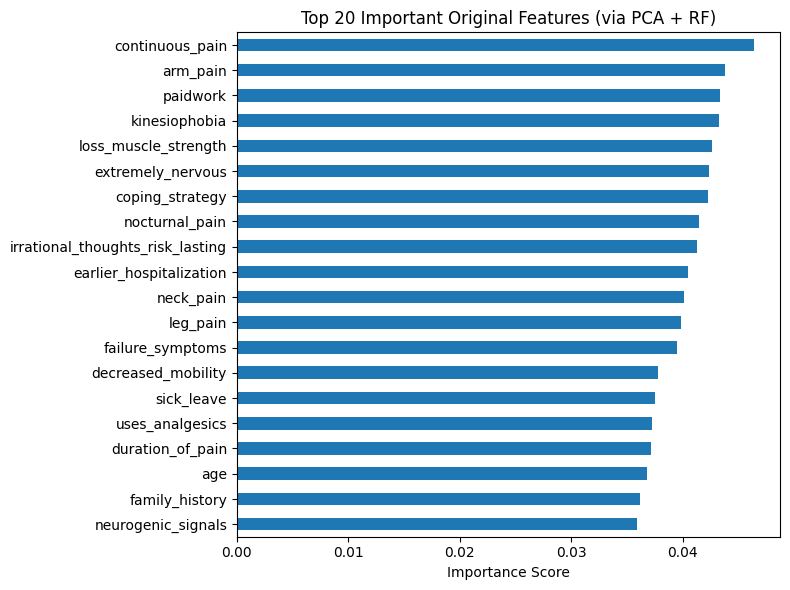

In [141]:
rf_model = pipeline.named_steps['classifier']
pca_model = pipeline.named_steps['pca']
importances = rf_model.feature_importances_
# Get PCA components matrix (shape: n_components x n_original_features)
pca_components = np.abs(pca_model.components_)

# Weighted contribution of each original feature
# (multiply each component's loadings by that PC's importance)
weighted = pca_components.T @ importances  # shape: (n_original_features,)

# Normalize
weighted /= weighted.sum()

# Map to original feature names
feature_scores = pd.Series(weighted, index=X_train.columns)
important_features = feature_scores.sort_values(ascending=False)
#print("Top contributing original features to PCA-RF model:")
##print(important_features.head(10))
important_features.head(20).plot(kind='barh', figsize=(8, 6))
plt.title('Top 20 Important Original Features (via PCA + RF)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Feature Selection with Univariate Statistical Tests

#### Without Oversampling and Undersampling

In [142]:
pipeline_kbest = ImbPipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50)),
    #('smote', over),
    #('undersample', under),
    ('scaler', StandardScaler()),
    #### ('pca', PCA(n_components=12)),  <-- commented out
    ('select', SelectKBest(score_func=f_classif, k=10)),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        n_estimators=1000,
        random_state=42
    ))
])
pipeline_kbest.fit(X_train, y_train)

pipeline_transform = ImbPipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50)),
    #('smote', over),
    #('undersample', under),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=12)),  # PCA back in here
    ('select', SelectKBest(score_func=f_classif, k=10))
])

# Transform X_train and X_test to selected PCA components
X_train_selected = pipeline_transform.fit_transform(X_train, y_train)
X_test_selected = pipeline_transform.transform(X_test)
# Train RF on selected components
pipeline_final_model = ImbPipeline(steps=[
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        n_estimators=500,
        random_state=42
    ))
])

pipeline_final_model.fit(X_train_selected, y_train)
score = pipeline_final_model.score(X_test_selected, y_test)
print(f"Test score (RF on selected PCA components): {score:.8f}")

Test score (RF on selected PCA components): 0.59073359


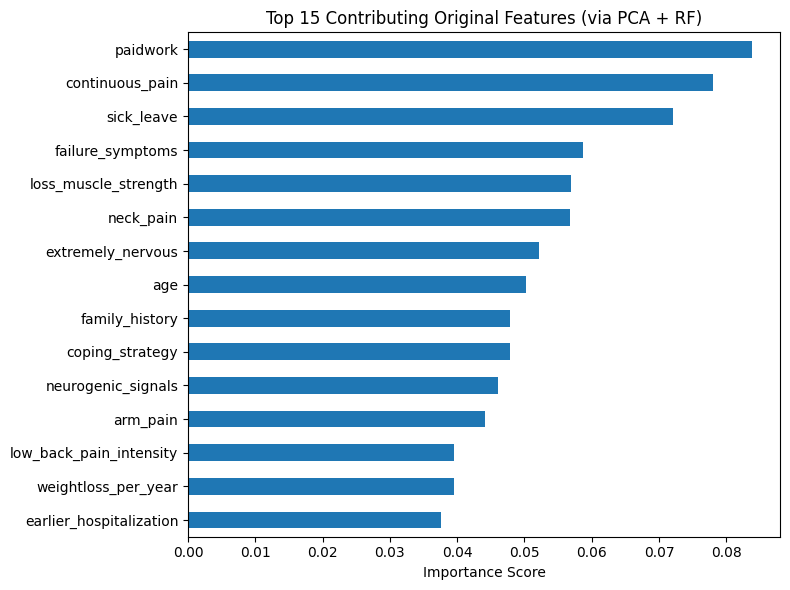

🔍 Top contributing original features:
paidwork                   0.083798
continuous_pain            0.078042
sick_leave                 0.072102
failure_symptoms           0.058638
loss_muscle_strength       0.056935
neck_pain                  0.056819
extremely_nervous          0.052227
age                        0.050202
family_history             0.047847
coping_strategy            0.047847
neurogenic_signals         0.046039
arm_pain                   0.044210
low_back_pain_intensity    0.039600
weightloss_per_year        0.039481
earlier_hospitalization    0.037541
dtype: float64


In [ ]:
pca_model = pipeline_transform.named_steps['pca']
selector = pipeline_transform.named_steps['select']
rf_model = pipeline_final_model.named_steps['classifier']

# Step 2: Get selected PCA components and their importances
selected_pc_indices = selector.get_support(indices=True)
selected_pca_components = pca_model.components_[selected_pc_indices]
rf_importances = rf_model.feature_importances_  # one per selected PC

# Step 3: Compute weighted contribution of each original feature
# Take absolute value of component loadings to avoid sign cancellation
weighted_contributions = np.abs(selected_pca_components.T @ rf_importances)
weighted_contributions /= weighted_contributions.sum()  # normalize to sum to 1

# Step 4: Map to original feature names
original_feature_names = X_train.columns
feature_importance_series = pd.Series(weighted_contributions, index=original_feature_names)
top_features = feature_importance_series.sort_values(ascending=False)

# Step 5: Plot top contributors
top_features.head(15).plot(kind='barh', figsize=(8, 6))
plt.title('Top 15 Contributing Original Features (via PCA + RF)')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Print top features
print("🔍 Top contributing original features:")
print(top_features.head(15))


#### With Oversampling and Undersampling

In [105]:
# Step 1: Preprocessing & Resampling on training data
resample_pipeline = ImbPipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50)),
    ('smote', SMOTE(random_state=42)),
    ('undersample', RandomUnderSampler(random_state=42))
])

X_resampled, y_resampled = resample_pipeline.fit_resample(X_train, y_train)

# 💡 Also impute X_test using the same imputer (fitted on X_train)
X_test_imputed = resample_pipeline.named_steps['imputer'].transform(X_test)

# Step 2: PCA + SelectKBest on resampled data
feature_selector = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=12)),
    ('select', SelectKBest(score_func=f_classif, k=10))
])

X_train_selected = feature_selector.fit_transform(X_resampled, y_resampled)
X_test_selected = feature_selector.transform(X_test_imputed)

# Step 3: Final model
final_model = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=500,
    random_state=42
)
final_model.fit(X_train_selected, y_resampled)
score = final_model.score(X_test_selected, y_test)
print(f"Test score (RF on selected PCA components with SMOTE + undersampling): {score:.8f}")


Test score (RF on selected PCA components with SMOTE + undersampling): 0.59073359


# XGBoost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Step 1: Transform pipeline with PCA + SelectKBest
pipeline_transform = ImbPipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=12)),
    ('select', SelectKBest(score_func=f_classif, k=10))
])

# Fit-transform training data
X_train_selected = pipeline_transform.fit_transform(X_train, y_train)

# Impute + transform test data step-by-step
X_test_imputed = pipeline_transform.named_steps['imputer'].transform(X_test)
X_test_scaled = pipeline_transform.named_steps['scaler'].transform(X_test_imputed)
X_test_pca = pipeline_transform.named_steps['pca'].transform(X_test_scaled)
X_test_selected = pipeline_transform.named_steps['select'].transform(X_test_pca)

# Step 2: Train Gradient Boosting model
gb_model = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    random_state=42
)

gb_model.fit(X_train_selected, y_train)
gb_score = gb_model.score(X_test_selected, y_test)
print(f"Test score (Gradient Boosting on selected PCA components): {gb_score:.8f}")

y_pred = gb_model.predict(X_test_selected)
print(classification_report(y_test, y_pred))


✅ Test score (Gradient Boosting on selected PCA components): 0.57142857
              precision    recall  f1-score   support

           0       0.58      0.53      0.55       131
           1       0.56      0.62      0.59       128

    accuracy                           0.57       259
   macro avg       0.57      0.57      0.57       259
weighted avg       0.57      0.57      0.57       259



# Support Vector Machine

In [119]:
from sklearn.svm import SVC
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import Pipeline as ImbPipeline

# Step 1: Preprocessing + PCA + SelectKBest
pipeline_transform = ImbPipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=12)),
    ('select', SelectKBest(score_func=f_classif, k=10))
])

# Transform training data
X_train_selected = pipeline_transform.fit_transform(X_train, y_train)

# Apply same transformation to test data
X_test_imputed = pipeline_transform.named_steps['imputer'].transform(X_test)
X_test_scaled = pipeline_transform.named_steps['scaler'].transform(X_test_imputed)
X_test_pca = pipeline_transform.named_steps['pca'].transform(X_test_scaled)
X_test_selected = pipeline_transform.named_steps['select'].transform(X_test_pca)

# Step 2: Fit SVM model
svm_model = SVC(kernel='linear', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_selected, y_train)

# Evaluate
svm_score = svm_model.score(X_test_selected, y_test)
print(f"✅ Test score (SVM on selected PCA components): {svm_score:.8f}")

from sklearn.metrics import classification_report

y_pred = svm_model.predict(X_test_selected)
print(classification_report(y_test, y_pred))



✅ Test score (SVM on selected PCA components): 0.56370656
              precision    recall  f1-score   support

           0       0.58      0.50      0.54       131
           1       0.55      0.62      0.59       128

    accuracy                           0.56       259
   macro avg       0.57      0.56      0.56       259
weighted avg       0.57      0.56      0.56       259



### Grid Search SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Step 1: Transform train and test data
X_train_selected = pipeline_transform.fit_transform(X_train, y_train)

# Apply the same preprocessing to test set
X_test_imputed = pipeline_transform.named_steps['imputer'].transform(X_test)
X_test_scaled = pipeline_transform.named_steps['scaler'].transform(X_test_imputed)
X_test_pca = pipeline_transform.named_steps['pca'].transform(X_test_scaled)
X_test_selected = pipeline_transform.named_steps['select'].transform(X_test_pca)

# Step 2: Define SVM and parameter grid
svm = SVC(random_state=42)
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Step 3: Grid search with 5-fold CV
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

# Step 4: Evaluate best model
print(f"✅ Best parameters: {grid_search.best_params_}")
print(f"✅ Best CV score: {grid_search.best_score_:.4f}")

best_svm = grid_search.best_estimator_
test_score = best_svm.score(X_test_selected, y_test)
print(f"✅ Test score (best SVM): {test_score:.4f}")

# Optional: Classification report
y_pred = best_svm.predict(X_test_selected)
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
✅ Best CV score: 0.5653
✅ Test score (best SVM): 0.5521
              precision    recall  f1-score   support

           0       0.56      0.50      0.53       131
           1       0.54      0.60      0.57       128

    accuracy                           0.55       259
   macro avg       0.55      0.55      0.55       259
weighted avg       0.55      0.55      0.55       259



## Logistic Regression

In [156]:
import statsmodels.api as sm
from sklearn.metrics import accuracy_score

# Step 1: Preprocess X
imputer = IterativeImputer(max_iter=50)
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Step 2: Add constant for intercept
X_train_sm = sm.add_constant(X_train_scaled)
X_test_sm = sm.add_constant(X_test_scaled)

# Step 3: Fit logistic regression using statsmodels
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Step 4: Predict probabilities and convert to class labels
y_prob = result.predict(X_test_sm)
y_pred = (y_prob > 0.5).astype(int)

# Step 5: Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"✅ Test accuracy (Logistic Regression): {acc:.4f}")
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

Optimization terminated successfully.
         Current function value: 0.664141
         Iterations 5
✅ Test accuracy (Logistic Regression): 0.5869
📋 Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.52      0.56       131
           1       0.57      0.66      0.61       128

    accuracy                           0.59       259
   macro avg       0.59      0.59      0.59       259
weighted avg       0.59      0.59      0.58       259



In [157]:
print(result.summary())
feature_names = ['const'] + list(X_train.columns)
summary_df = pd.DataFrame({
    "Feature": feature_names,
    "Coef": result.params,
    "StdErr": result.bse,
    "z-value": result.tvalues,
    "p-value": result.pvalues,
    "CI Lower": result.conf_int()[0],
    "CI Upper": result.conf_int()[1],
}).set_index("Feature")

print("\n !!! Top features by statistical significance:")
print(summary_df.sort_values(by="p-value").head(10))

                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                 1033
Model:                          Logit   Df Residuals:                     1005
Method:                           MLE   Df Model:                           27
Date:                Thu, 03 Apr 2025   Pseudo R-squ.:                 0.04181
Time:                        13:31:02   Log-Likelihood:                -686.06
converged:                       True   LL-Null:                       -716.00
Covariance Type:            nonrobust   LLR p-value:                 0.0002736
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0214      0.064     -0.334      0.738      -0.147       0.104
x1            -0.0552      0.072     -0.768      0.443      -0.196       0.086
x2            -0.0299      0.070     -0.425      0.6